<a href="https://colab.research.google.com/github/ArwaASM/TPE/blob/main/Models_Evaluation_and_Confusion_Matrices_(Faster_RCNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Checking GPU Access**

In [1]:
!nvidia-smi

Fri Dec 27 01:32:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## **Inatall Detectron2**

In [2]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
torch:  2.5 ; cuda:  cu121
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-4gw_f5js
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-4gw_f5js
  Resolved https://github.com/facebookresearch/detectron2.git to commit b1c43ffbc995426a9a6b5c667730091a384e0fa4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
# Detectron2 and necessary libraries
!pip install detectron2
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Other required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


## **Import our Dataset**

In [5]:
!curl -L "https://app.roboflow.com/ds/YJev0eedEd?key=jafcYQcnNs" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   3476      0 --:--:-- --:--:-- --:--:--  3465
100 29.4M  100 29.4M    0     0  40.4M      0 --:--:-- --:--:-- --:--:-- 40.4M
Archive:  roboflow.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
   creating: test/
 extracting: test/2024_05_07_07_39_IMG_1266_MOV-0010_jpg.rf.20a99cec7de825bc38f7f75bf2904c21.jpg  
 extracting: test/2024_05_07_07_39_IMG_1266_MOV-0017_jpg.rf.8d1e62e0299c5fcc5e33e70ea6df3f16.jpg  
 extracting: test/2024_05_07_07_39_IMG_1266_MOV-0027_jpg.rf.80ca7d714fa4164c2d63ae5414f09f17.jpg  
 extracting: test/2024_05_07_07_39_IMG_1266_MOV-0040_jpg.rf.908476d825252a8ea97df9a088a08410.jpg  
 extracting: test/2024_05_07_07_39_IMG_1266_MOV-0076_jpg.rf.1e11ec3995f55e529c4adb0a8a1ea158.jpg  
 extracting: test/2024_05_07_07_39_IMG_1266_MOV-0096_jpg.rf.846c195c082

## **Dataset Registration**

In [6]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")
register_coco_instances("my_dataset_valid", {}, "/content/valid/_annotations.coco.json", "/content/valid")

In [6]:
test_dataset = "my_dataset_test"  # replace with your dataset name
metadata = MetadataCatalog.get(test_dataset)

## **Model Evaluation**

## **1.1. Faster-RCNN_R_50 without SNMS**

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))  # replace with your config path
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/AAbFFSSNew/Final_Results_14_11/Models_Training_and_Testing/output_FRCNN_50/model_final.pth"  # path to your trained model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for inference
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 11  # number of classes in your dataset
predictor = DefaultPredictor(cfg)

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Initialize COCO Evaluator
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="/content/FRCNN_R_50_No_SNMS/")
test_loader = build_detection_test_loader(cfg, "my_dataset_test")

# Run evaluation
eval_results = inference_on_dataset(predictor.model, test_loader, evaluator)
print("Evaluation Results:\n", eval_results)


[12/27 01:48:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/AAbFFSSNew/Final_Results_14_11/Models_Training_and_Testing/output_FRCNN_50/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

WARNING [12/27 01:48:31 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/27 01:48:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/27 01:48:31 d2.data.datasets.coco]: Loaded 453 images in COCO format from /content/test/_annotations.coco.json
[12/27 01:48:31 d2.data.build]: Distribution of instances among all 12 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|  Annotation   | 0            |  Closed-Book  | 339          | Electronic-.. | 21           |
|    No-Book    | 332          |  Opened-Book  | 654          | Raising-Hand  | 221          |
| Student-Ans.. | 69           | Student-Reads | 62           | Student-Wri.. | 45           |
| Teacher-Exp.. | 6

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/27 01:48:34 d2.evaluation.evaluator]: Inference done 11/453. Dataloading: 0.0010 s/iter. Inference: 0.0264 s/iter. Eval: 0.0003 s/iter. Total: 0.0277 s/iter. ETA=0:00:12
[12/27 01:48:39 d2.evaluation.evaluator]: Inference done 191/453. Dataloading: 0.0013 s/iter. Inference: 0.0262 s/iter. Eval: 0.0003 s/iter. Total: 0.0278 s/iter. ETA=0:00:07
[12/27 01:48:44 d2.evaluation.evaluator]: Inference done 374/453. Dataloading: 0.0013 s/iter. Inference: 0.0259 s/iter. Eval: 0.0003 s/iter. Total: 0.0276 s/iter. ETA=0:00:02
[12/27 01:48:47 d2.evaluation.evaluator]: Total inference time: 0:00:12.318744 (0.027497 s / iter per device, on 1 devices)
[12/27 01:48:47 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:11 (0.025780 s / iter per device, on 1 devices)
[12/27 01:48:47 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/27 01:48:47 d2.evaluation.coco_evaluation]: Saving results to /content/FRCNN_R_50_No_SNMS/coco_instances_results.json
[12/27 01:48:4

## **1.2. Faster-RCNN_R_50 with SNMS**

In [8]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures import Boxes, Instances
import torch
import numpy as np

# Define the Soft-NMS function
def soft_nms(boxes, scores, labels, iou_threshold=0.5, sigma=0.5, method="linear"):
    """
    Perform Soft-NMS on the given boxes, scores, and labels.
    Args:
        boxes (numpy.ndarray): Bounding boxes, shape (N, 4).
        scores (numpy.ndarray): Scores for each box, shape (N,).
        labels (numpy.ndarray): Labels for each box, shape (N,).
        iou_threshold (float): IoU threshold for NMS.
        sigma (float): Sigma for Gaussian Soft-NMS.
        method (str): "linear", "gaussian", or "hard" for Soft-NMS.
    Returns:
        keep (list): Indices of the boxes to keep.
    """
    N = len(scores)
    indices = np.arange(N)
    keep = []

    while len(indices) > 0:
        max_idx = np.argmax(scores[indices])
        current = indices[max_idx]
        keep.append(current)

        if len(indices) == 1:
            break

        current_box = boxes[current]
        remaining_boxes = boxes[indices]
        ious = compute_iou(current_box, remaining_boxes)

        if method == "linear":
            scores[indices] *= (1 - ious)
        elif method == "gaussian":
            scores[indices] *= np.exp(-(ious ** 2) / sigma)
        elif method == "hard":
            scores[indices][ious > iou_threshold] = 0

        indices = indices[scores[indices] > 0]

    return keep

def compute_iou(box, boxes):
    """
    Compute IoU between a box and a set of boxes.
    Args:
        box (numpy.ndarray): A single box, shape (4,).
        boxes (numpy.ndarray): A set of boxes, shape (N, 4).
    Returns:
        ious (numpy.ndarray): IoU values, shape (N,).
    """
    x1 = np.maximum(box[0], boxes[:, 0])
    y1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[2], boxes[:, 2])
    y2 = np.minimum(box[3], boxes[:, 3])

    inter_area = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    union_area = box_area + boxes_area - inter_area
    ious = inter_area / np.maximum(union_area, 1e-6)
    return ious

def apply_soft_nms(predictions, iou_threshold=0.5, sigma=0.5, method="linear"):
    """
    Applies Soft-NMS to the predictions.
    Args:
        predictions (Instances): Model predictions.
        iou_threshold (float): IoU threshold for NMS.
        sigma (float): Sigma value for Gaussian Soft-NMS.
        method (str): "linear", "gaussian", or "hard" for Soft-NMS.
    Returns:
        Instances: Predictions after applying Soft-NMS.
    """
    boxes = predictions.pred_boxes.tensor.detach().cpu().numpy()
    scores = predictions.scores.detach().cpu().numpy()
    labels = predictions.pred_classes.detach().cpu().numpy()

    # Apply Soft-NMS
    keep = soft_nms(boxes, scores, labels, iou_threshold=iou_threshold, sigma=sigma, method=method)

    # Keep only the predictions after Soft-NMS
    predictions = predictions[keep]
    return predictions

# Load the model configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))  # replace with your config path
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/AAbFFSSNew/Final_Results_14_11/Models_Training_and_Testing/output_FRCNN_50/model_final.pth"  # path to your trained model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for inference
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 11  # number of classes in your dataset

# Build model and predictor
model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
predictor = DefaultPredictor(cfg)

# Initialize COCO Evaluator
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="/content/FRCNN_R_50_SNMS/")
evaluator._predictions = []  # Initialize _predictions attribute to avoid AttributeError
test_loader = build_detection_test_loader(cfg, "my_dataset_test")

# Run evaluation with Soft-NMS applied
def inference_with_soft_nms(predictor, data_loader, evaluator, iou_threshold=0.5, sigma=0.5, method="linear"):
    """
    Perform inference with Soft-NMS applied to predictions.
    """
    model = predictor.model
    model.eval()

    for idx, inputs in enumerate(data_loader):
        outputs = model(inputs)
        for output in outputs:
            output["instances"] = apply_soft_nms(output["instances"], iou_threshold, sigma, method)

        # Ensure tensors are detached before processing
        for output in outputs:
            output["instances"].pred_boxes.tensor = output["instances"].pred_boxes.tensor.detach()

        evaluator.process(inputs, outputs)

    return evaluator.evaluate()

# Perform evaluation
eval_results = inference_with_soft_nms(predictor, test_loader, evaluator, iou_threshold=0.5, sigma=0.5, method="linear")
print("Evaluation Results with Soft-NMS:\n", eval_results)



[12/27 01:48:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/AAbFFSSNew/Final_Results_14_11/Models_Training_and_Testing/output_FRCNN_50/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[12/27 01:48:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/AAbFFSSNew/Final_Results_14_11/Models_Training_and_Testing/output_FRCNN_50/model_final.pth ...
WARNING [12/27 01:48:56 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/27 01:48:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/27 01:48:57 d2.data.datasets.coco]: Loaded 453 images in COCO format from /content/test/_annotations.coco.json
[12/27 01:48:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/27 01:48:57 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/27 01:48:57 d2.data.common]: Serializing 453 elements to byte tensor

## **Generate Confusion Matrix Faster-RCNN_R_50**

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.46s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.727
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.530
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.560
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

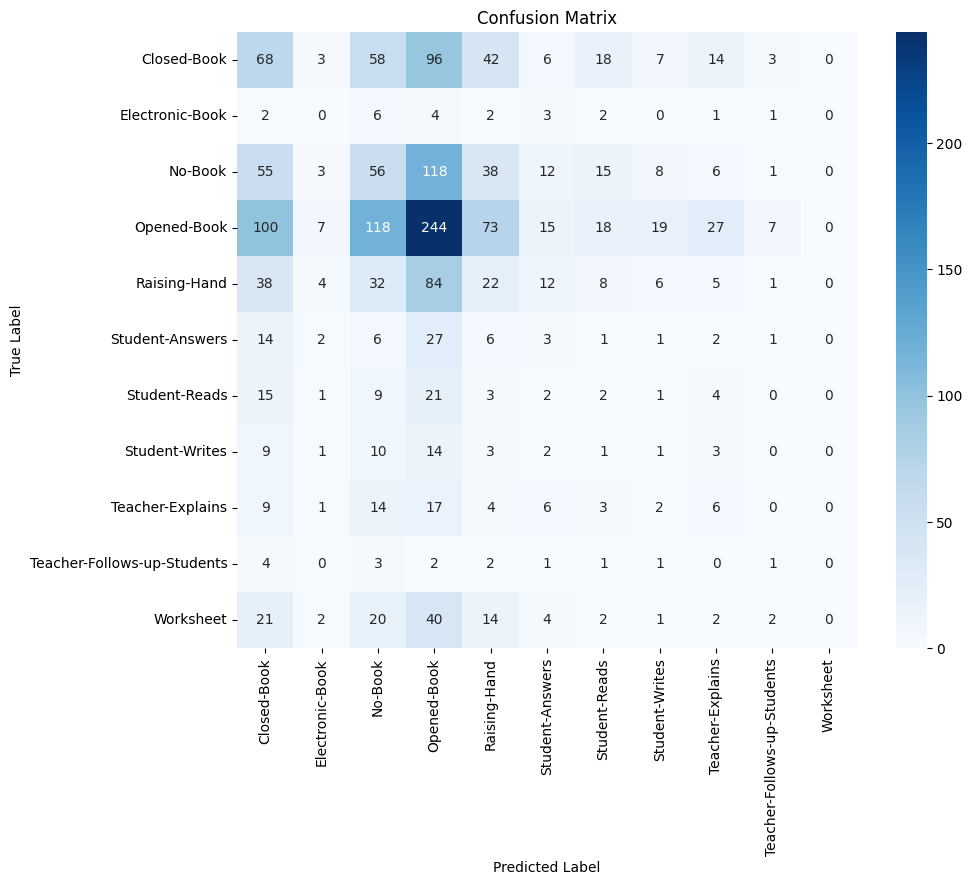

                             precision    recall  f1-score   support

              Student-Reads       0.03      0.03      0.03        58
            Electronic-Book       0.00      0.00      0.00        21
                  Worksheet       0.00      0.00      0.00       108
Teacher-Follows-up-Students       0.06      0.07      0.06        15
                Closed-Book       0.20      0.22      0.21       315
             Student-Writes       0.02      0.02      0.02        44
            Student-Answers       0.05      0.05      0.05        63
                Opened-Book       0.37      0.39      0.38       628
           Teacher-Explains       0.09      0.10      0.09        62
               Raising-Hand       0.11      0.10      0.10       212
                    No-Book       0.17      0.18      0.17       312

                   accuracy                           0.22      1838
                  macro avg       0.10      0.11      0.10      1838
               weighted avg     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Load ground truth and predictions
coco_gt = COCO('/content/test/_annotations.coco.json')
coco_dt = coco_gt.loadRes('/content/FRCNN_R_50_SNMS/coco_instances_results.json')

# Category mapping
category_mapping = {
    1: 'Closed-Book', 2: 'Electronic-Book', 3: 'No-Book', 4: 'Opened-Book', 5: 'Raising-Hand',
    6: 'Student-Answers', 7: 'Student-Reads', 8: 'Student-Writes', 9: 'Teacher-Explains',
    10: 'Teacher-Follows-up-Students', 11: 'Worksheet'
}

# Perform COCO evaluation (for mAP and IoU)
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Extract mAP and AR for further analysis
mAP_50_95 = coco_eval.stats[0]  # mAP @ [0.5:0.95]
mAP_50 = coco_eval.stats[1]      # mAP @ 0.50
average_recall = coco_eval.stats[8]

# Initialize lists for true and predicted labels
true_labels = []
pred_labels = []

# Extract true labels from ground truth annotations and predicted labels from detection results
for img_id in coco_gt.getImgIds():
    ann_ids = coco_gt.getAnnIds(imgIds=img_id)
    anns = coco_gt.loadAnns(ann_ids)

    dt_ids = coco_dt.getAnnIds(imgIds=img_id)
    dts = coco_dt.loadAnns(dt_ids)

    # Add ground truth and predicted labels to the lists
    for ann in anns:
        true_labels.append(ann['category_id'])
    for dt in dts:
        pred_labels.append(dt['category_id'])

# Convert category_ids to category names for true and predicted labels
true_labels_names = [category_mapping[cat_id] for cat_id in true_labels if cat_id in category_mapping]
pred_labels_names = [category_mapping[cat_id] for cat_id in pred_labels if cat_id in category_mapping]

# Ensure both true_labels_names and pred_labels_names have the same length
min_length = min(len(true_labels_names), len(pred_labels_names))
true_labels_trimmed = true_labels_names[:min_length]
pred_labels_trimmed = pred_labels_names[:min_length]

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels_trimmed, pred_labels_trimmed, labels=list(category_mapping.values()))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=category_mapping.values(), yticklabels=category_mapping.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix')
plt.show()

# Get unique labels from trimmed true and predicted labels
unique_labels = list(set(true_labels_trimmed) | set(pred_labels_trimmed))

# Classification report (Precision, Recall, F1-score per class)
print(classification_report(true_labels_trimmed, pred_labels_trimmed, target_names=unique_labels, labels=unique_labels))

# IoU Calculation Function
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    inter_x1 = max(x1, x1_)
    inter_y1 = max(y1, y1_)
    inter_x2 = min(x2, x2_)
    inter_y2 = min(y2, y2_)

    inter_width = max(0, inter_x2 - inter_x1)
    inter_height = max(0, inter_y2 - inter_y1)
    intersection = inter_width * inter_height

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_ - x1_) * (y2_ - y1_)
    union = box1_area + box2_area - intersection

    iou = intersection / union if union != 0 else 0
    return iou

# Example bounding boxes
box1 = [100, 150, 200, 250]
box2 = [120, 170, 220, 270]

# Calculate IoU between box1 and box2
iou = compute_iou(box1, box2)
print(f"IoU between two boxes: {iou}")


## **2.1. Faster-RCNN_R_101 without SNMS**

In [10]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))  # replace with your config path
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/AAbFFSSNew/Final_Results_14_11/Models_Training_and_Testing/output_R101FRCNN/model_final.pth"  # path to your trained model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for inference
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 11  # number of classes in your dataset
predictor = DefaultPredictor(cfg)

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Initialize COCO Evaluator
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="/content/FRCNN_R_101_No_SNMS/")
test_loader = build_detection_test_loader(cfg, "my_dataset_test")

# Run evaluation
eval_results = inference_on_dataset(predictor.model, test_loader, evaluator)
print("Evaluation Results:\n", eval_results)


[12/27 01:53:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/AAbFFSSNew/Final_Results_14_11/Models_Training_and_Testing/output_R101FRCNN/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

WARNING [12/27 01:53:17 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/27 01:53:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/27 01:53:17 d2.data.datasets.coco]: Loaded 453 images in COCO format from /content/test/_annotations.coco.json
[12/27 01:53:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/27 01:53:17 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/27 01:53:17 d2.data.common]: Serializing 453 elements to byte tensors and concatenating them all ...
[12/27 01:53:17 d2.data.common]: Serialized dataset takes 0.18 MiB
[12/27 01:53:17 d2.evaluation.evaluator]: Start inference on 453 batches
[12/27 01:53:18 d2.evaluation.evalu

## **2.2. Faster-RCNN_R_101 with SNMS**

In [11]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures import Boxes, Instances
import torch
import numpy as np

# Define the Soft-NMS function
def soft_nms(boxes, scores, labels, iou_threshold=0.5, sigma=0.5, method="linear"):
    """
    Perform Soft-NMS on the given boxes, scores, and labels.
    Args:
        boxes (numpy.ndarray): Bounding boxes, shape (N, 4).
        scores (numpy.ndarray): Scores for each box, shape (N,).
        labels (numpy.ndarray): Labels for each box, shape (N,).
        iou_threshold (float): IoU threshold for NMS.
        sigma (float): Sigma for Gaussian Soft-NMS.
        method (str): "linear", "gaussian", or "hard" for Soft-NMS.
    Returns:
        keep (list): Indices of the boxes to keep.
    """
    N = len(scores)
    indices = np.arange(N)
    keep = []

    while len(indices) > 0:
        max_idx = np.argmax(scores[indices])
        current = indices[max_idx]
        keep.append(current)

        if len(indices) == 1:
            break

        current_box = boxes[current]
        remaining_boxes = boxes[indices]
        ious = compute_iou(current_box, remaining_boxes)

        if method == "linear":
            scores[indices] *= (1 - ious)
        elif method == "gaussian":
            scores[indices] *= np.exp(-(ious ** 2) / sigma)
        elif method == "hard":
            scores[indices][ious > iou_threshold] = 0

        indices = indices[scores[indices] > 0]

    return keep

def compute_iou(box, boxes):
    """
    Compute IoU between a box and a set of boxes.
    Args:
        box (numpy.ndarray): A single box, shape (4,).
        boxes (numpy.ndarray): A set of boxes, shape (N, 4).
    Returns:
        ious (numpy.ndarray): IoU values, shape (N,).
    """
    x1 = np.maximum(box[0], boxes[:, 0])
    y1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[2], boxes[:, 2])
    y2 = np.minimum(box[3], boxes[:, 3])

    inter_area = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    union_area = box_area + boxes_area - inter_area
    ious = inter_area / np.maximum(union_area, 1e-6)
    return ious

def apply_soft_nms(predictions, iou_threshold=0.5, sigma=0.5, method="linear"):
    """
    Applies Soft-NMS to the predictions.
    Args:
        predictions (Instances): Model predictions.
        iou_threshold (float): IoU threshold for NMS.
        sigma (float): Sigma value for Gaussian Soft-NMS.
        method (str): "linear", "gaussian", or "hard" for Soft-NMS.
    Returns:
        Instances: Predictions after applying Soft-NMS.
    """
    boxes = predictions.pred_boxes.tensor.detach().cpu().numpy()
    scores = predictions.scores.detach().cpu().numpy()
    labels = predictions.pred_classes.detach().cpu().numpy()

    # Apply Soft-NMS
    keep = soft_nms(boxes, scores, labels, iou_threshold=iou_threshold, sigma=sigma, method=method)

    # Keep only the predictions after Soft-NMS
    predictions = predictions[keep]
    return predictions

# Load the model configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))  # replace with your config path
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/AAbFFSSNew/Final_Results_14_11/Models_Training_and_Testing/output_R101FRCNN/model_final.pth"  # path to your trained model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for inference
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 11  # number of classes in your dataset

# Build model and predictor
model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
predictor = DefaultPredictor(cfg)

# Initialize COCO Evaluator
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="/content/FRCNN_R_101_SNMS/")
evaluator._predictions = []  # Initialize _predictions attribute to avoid AttributeError
test_loader = build_detection_test_loader(cfg, "my_dataset_test")

# Run evaluation with Soft-NMS applied
def inference_with_soft_nms(predictor, data_loader, evaluator, iou_threshold=0.5, sigma=0.5, method="linear"):
    """
    Perform inference with Soft-NMS applied to predictions.
    """
    model = predictor.model
    model.eval()

    for idx, inputs in enumerate(data_loader):
        outputs = model(inputs)
        for output in outputs:
            output["instances"] = apply_soft_nms(output["instances"], iou_threshold, sigma, method)

        # Ensure tensors are detached before processing
        for output in outputs:
            output["instances"].pred_boxes.tensor = output["instances"].pred_boxes.tensor.detach()

        evaluator.process(inputs, outputs)

    return evaluator.evaluate()

# Perform evaluation
eval_results = inference_with_soft_nms(predictor, test_loader, evaluator, iou_threshold=0.5, sigma=0.5, method="linear")
print("Evaluation Results with Soft-NMS101:\n", eval_results)



[12/27 02:09:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/AAbFFSSNew/Final_Results_14_11/Models_Training_and_Testing/output_R101FRCNN/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[12/27 02:09:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/AAbFFSSNew/Final_Results_14_11/Models_Training_and_Testing/output_R101FRCNN/model_final.pth ...
WARNING [12/27 02:09:18 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/27 02:09:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/27 02:09:18 d2.data.datasets.coco]: Loaded 453 images in COCO format from /content/test/_annotations.coco.json
[12/27 02:09:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/27 02:09:18 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/27 02:09:18 d2.data.common]: Serializing 453 elements to byte tenso

## **Generate Confusion Matrix Faster-RCNN_R_101**

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.22s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.48s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.714
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.538
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.528
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.374
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.562
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

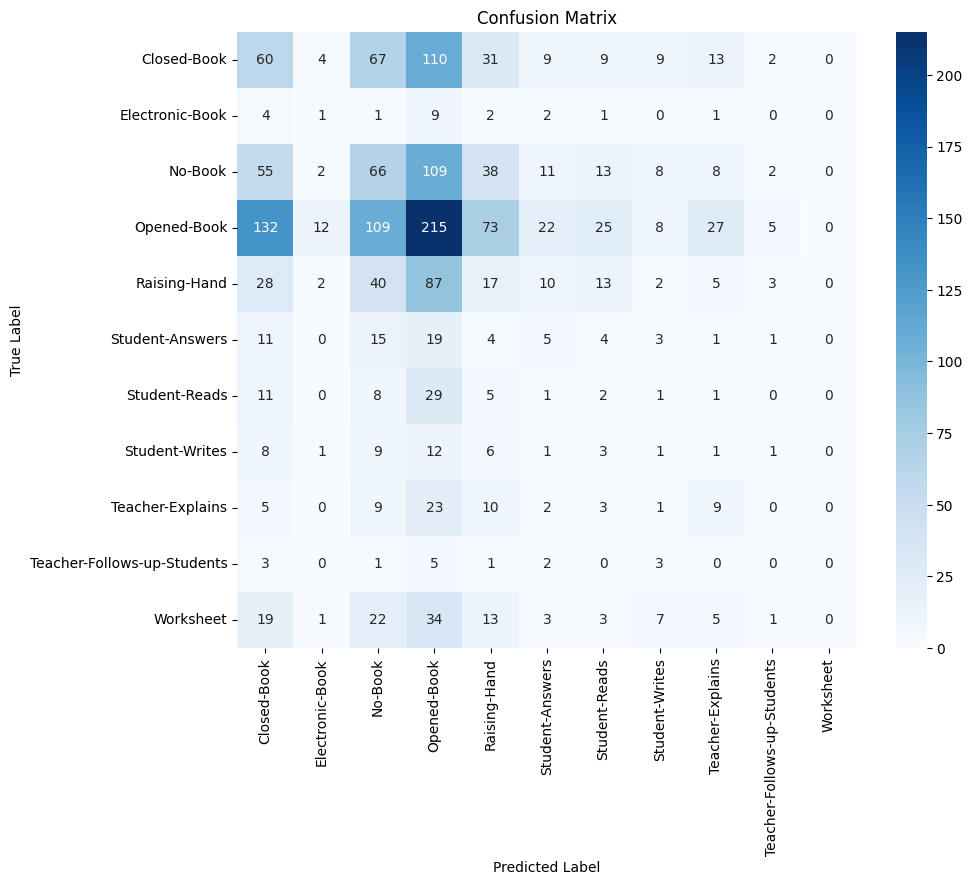

                             precision    recall  f1-score   support

              Student-Reads       0.03      0.03      0.03        58
            Electronic-Book       0.04      0.05      0.05        21
                  Worksheet       0.00      0.00      0.00       108
Teacher-Follows-up-Students       0.00      0.00      0.00        15
                Closed-Book       0.18      0.19      0.18       314
             Student-Writes       0.02      0.02      0.02        43
            Student-Answers       0.07      0.08      0.08        63
                Opened-Book       0.33      0.34      0.34       628
           Teacher-Explains       0.13      0.15      0.14        62
               Raising-Hand       0.09      0.08      0.08       207
                    No-Book       0.19      0.21      0.20       312

                   accuracy                           0.21      1831
                  macro avg       0.10      0.11      0.10      1831
               weighted avg     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Load ground truth and predictions
coco_gt = COCO('/content/test/_annotations.coco.json')
coco_dt = coco_gt.loadRes('/content/FRCNN_R_101_SNMS/coco_instances_results.json')

# Category mapping
category_mapping = {
    1: 'Closed-Book', 2: 'Electronic-Book', 3: 'No-Book', 4: 'Opened-Book', 5: 'Raising-Hand',
    6: 'Student-Answers', 7: 'Student-Reads', 8: 'Student-Writes', 9: 'Teacher-Explains',
    10: 'Teacher-Follows-up-Students', 11: 'Worksheet'
}

# Perform COCO evaluation (for mAP and IoU)
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Extract mAP and AR for further analysis
mAP_50_95 = coco_eval.stats[0]  # mAP @ [0.5:0.95]
mAP_50 = coco_eval.stats[1]      # mAP @ 0.50
average_recall = coco_eval.stats[8]

# Initialize lists for true and predicted labels
true_labels = []
pred_labels = []

# Extract true labels from ground truth annotations and predicted labels from detection results
for img_id in coco_gt.getImgIds():
    ann_ids = coco_gt.getAnnIds(imgIds=img_id)
    anns = coco_gt.loadAnns(ann_ids)

    dt_ids = coco_dt.getAnnIds(imgIds=img_id)
    dts = coco_dt.loadAnns(dt_ids)

    # Add ground truth and predicted labels to the lists
    for ann in anns:
        true_labels.append(ann['category_id'])
    for dt in dts:
        pred_labels.append(dt['category_id'])

# Convert category_ids to category names for true and predicted labels
true_labels_names = [category_mapping[cat_id] for cat_id in true_labels if cat_id in category_mapping]
pred_labels_names = [category_mapping[cat_id] for cat_id in pred_labels if cat_id in category_mapping]

# Ensure both true_labels_names and pred_labels_names have the same length
min_length = min(len(true_labels_names), len(pred_labels_names))
true_labels_trimmed = true_labels_names[:min_length]
pred_labels_trimmed = pred_labels_names[:min_length]

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels_trimmed, pred_labels_trimmed, labels=list(category_mapping.values()))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=category_mapping.values(), yticklabels=category_mapping.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix')
plt.show()

# Get unique labels from trimmed true and predicted labels
unique_labels = list(set(true_labels_trimmed) | set(pred_labels_trimmed))

# Classification report (Precision, Recall, F1-score per class)
print(classification_report(true_labels_trimmed, pred_labels_trimmed, target_names=unique_labels, labels=unique_labels))

# IoU Calculation Function
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    inter_x1 = max(x1, x1_)
    inter_y1 = max(y1, y1_)
    inter_x2 = min(x2, x2_)
    inter_y2 = min(y2, y2_)

    inter_width = max(0, inter_x2 - inter_x1)
    inter_height = max(0, inter_y2 - inter_y1)
    intersection = inter_width * inter_height

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_ - x1_) * (y2_ - y1_)
    union = box1_area + box2_area - intersection

    iou = intersection / union if union != 0 else 0
    return iou

# Example bounding boxes
box1 = [100, 150, 200, 250]
box2 = [120, 170, 220, 270]

# Calculate IoU between box1 and box2
iou = compute_iou(box1, box2)
print(f"IoU between two boxes: {iou}")


## **3.1. Faster-RCNN_RX_101 without SNMs**

In [13]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))  # replace with your config path
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/AAbFFSSNew/Final_Results_14_11/Models_Training_and_Testing/output_FasterR-CNN_RX_101_3x/model_0034999.pth"  # path to your trained model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for inference
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 11  # number of classes in your dataset
predictor = DefaultPredictor(cfg)

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Initialize COCO Evaluator
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="/content/FRCNN_RX_101_No_SNMS/")
test_loader = build_detection_test_loader(cfg, "my_dataset_test")

# Run evaluation
eval_results = inference_on_dataset(predictor.model, test_loader, evaluator)
print("Evaluation Results:\n", eval_results)


[12/27 02:15:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/AAbFFSSNew/Final_Results_14_11/Models_Training_and_Testing/output_FasterR-CNN_RX_101_3x/model_0034999.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

WARNING [12/27 02:15:50 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/27 02:15:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/27 02:15:50 d2.data.datasets.coco]: Loaded 453 images in COCO format from /content/test/_annotations.coco.json
[12/27 02:15:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/27 02:15:50 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/27 02:15:50 d2.data.common]: Serializing 453 elements to byte tensors and concatenating them all ...
[12/27 02:15:50 d2.data.common]: Serialized dataset takes 0.18 MiB
[12/27 02:15:50 d2.evaluation.evaluator]: Start inference on 453 batches
[12/27 02:15:51 d2.evaluation.evalu

## **3.2. Faster-RCNN_RX_101 with SNMs**

In [14]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures import Boxes, Instances
import torch
import numpy as np

# Define the Soft-NMS function
def soft_nms(boxes, scores, labels, iou_threshold=0.5, sigma=0.5, method="linear"):
    """
    Perform Soft-NMS on the given boxes, scores, and labels.
    Args:
        boxes (numpy.ndarray): Bounding boxes, shape (N, 4).
        scores (numpy.ndarray): Scores for each box, shape (N,).
        labels (numpy.ndarray): Labels for each box, shape (N,).
        iou_threshold (float): IoU threshold for NMS.
        sigma (float): Sigma for Gaussian Soft-NMS.
        method (str): "linear", "gaussian", or "hard" for Soft-NMS.
    Returns:
        keep (list): Indices of the boxes to keep.
    """
    N = len(scores)
    indices = np.arange(N)
    keep = []

    while len(indices) > 0:
        max_idx = np.argmax(scores[indices])
        current = indices[max_idx]
        keep.append(current)

        if len(indices) == 1:
            break

        current_box = boxes[current]
        remaining_boxes = boxes[indices]
        ious = compute_iou(current_box, remaining_boxes)

        if method == "linear":
            scores[indices] *= (1 - ious)
        elif method == "gaussian":
            scores[indices] *= np.exp(-(ious ** 2) / sigma)
        elif method == "hard":
            scores[indices][ious > iou_threshold] = 0

        indices = indices[scores[indices] > 0]

    return keep

def compute_iou(box, boxes):
    """
    Compute IoU between a box and a set of boxes.
    Args:
        box (numpy.ndarray): A single box, shape (4,).
        boxes (numpy.ndarray): A set of boxes, shape (N, 4).
    Returns:
        ious (numpy.ndarray): IoU values, shape (N,).
    """
    x1 = np.maximum(box[0], boxes[:, 0])
    y1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[2], boxes[:, 2])
    y2 = np.minimum(box[3], boxes[:, 3])

    inter_area = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    union_area = box_area + boxes_area - inter_area
    ious = inter_area / np.maximum(union_area, 1e-6)
    return ious

def apply_soft_nms(predictions, iou_threshold=0.5, sigma=0.5, method="linear"):
    """
    Applies Soft-NMS to the predictions.
    Args:
        predictions (Instances): Model predictions.
        iou_threshold (float): IoU threshold for NMS.
        sigma (float): Sigma value for Gaussian Soft-NMS.
        method (str): "linear", "gaussian", or "hard" for Soft-NMS.
    Returns:
        Instances: Predictions after applying Soft-NMS.
    """
    boxes = predictions.pred_boxes.tensor.detach().cpu().numpy()
    scores = predictions.scores.detach().cpu().numpy()
    labels = predictions.pred_classes.detach().cpu().numpy()

    # Apply Soft-NMS
    keep = soft_nms(boxes, scores, labels, iou_threshold=iou_threshold, sigma=sigma, method=method)

    # Keep only the predictions after Soft-NMS
    predictions = predictions[keep]
    return predictions

# Load the model configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))  # replace with your config path
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/AAbFFSSNew/Final_Results_14_11/Models_Training_and_Testing/output_FasterR-CNN_RX_101_3x/model_0034999.pth"  # path to your trained model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for inference
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 11  # number of classes in your dataset

# Build model and predictor
model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
predictor = DefaultPredictor(cfg)

# Initialize COCO Evaluator
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="/content/FRCNN_RX_101_SNMS/")
evaluator._predictions = []  # Initialize _predictions attribute to avoid AttributeError
test_loader = build_detection_test_loader(cfg, "my_dataset_test")

# Run evaluation with Soft-NMS applied
def inference_with_soft_nms(predictor, data_loader, evaluator, iou_threshold=0.5, sigma=0.5, method="linear"):
    """
    Perform inference with Soft-NMS applied to predictions.
    """
    model = predictor.model
    model.eval()

    for idx, inputs in enumerate(data_loader):
        outputs = model(inputs)
        for output in outputs:
            output["instances"] = apply_soft_nms(output["instances"], iou_threshold, sigma, method)

        # Ensure tensors are detached before processing
        for output in outputs:
            output["instances"].pred_boxes.tensor = output["instances"].pred_boxes.tensor.detach()

        evaluator.process(inputs, outputs)

    return evaluator.evaluate()

# Perform evaluation
eval_results = inference_with_soft_nms(predictor, test_loader, evaluator, iou_threshold=0.5, sigma=0.5, method="linear")
print("Evaluation Results with Soft-NMSX101:\n", eval_results)



[12/27 02:17:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/AAbFFSSNew/Final_Results_14_11/Models_Training_and_Testing/output_FasterR-CNN_RX_101_3x/model_0034999.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[12/27 02:17:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/AAbFFSSNew/Final_Results_14_11/Models_Training_and_Testing/output_FasterR-CNN_RX_101_3x/model_0034999.pth ...
WARNING [12/27 02:17:10 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/27 02:17:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/27 02:17:10 d2.data.datasets.coco]: Loaded 453 images in COCO format from /content/test/_annotations.coco.json
[12/27 02:17:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/27 02:17:10 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/27 02:17:10 d2.data.common]: Serializing 453 elements

## **Generate Confusion Matrix Faster-RCNN_RX_101**

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.46s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.716
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.564
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.513
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.558
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.560
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

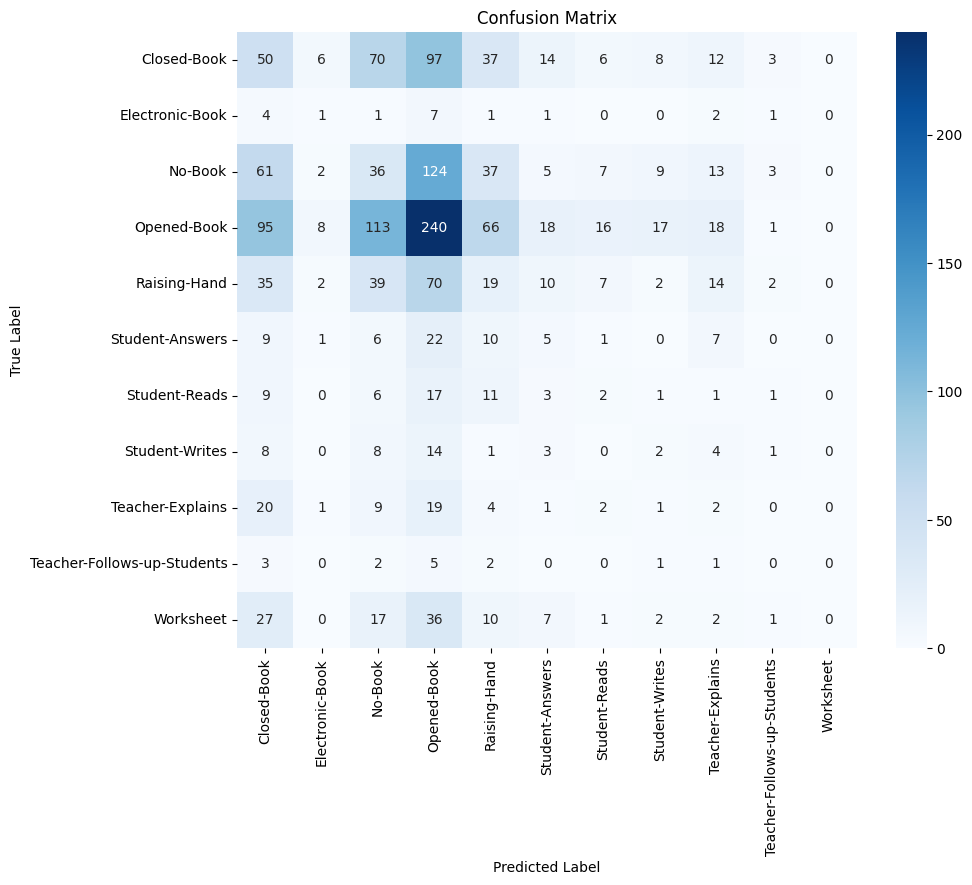

                             precision    recall  f1-score   support

              Student-Reads       0.05      0.04      0.04        51
            Electronic-Book       0.05      0.06      0.05        18
                  Worksheet       0.00      0.00      0.00       103
Teacher-Follows-up-Students       0.00      0.00      0.00        14
                Closed-Book       0.16      0.17      0.16       303
             Student-Writes       0.05      0.05      0.05        41
            Student-Answers       0.07      0.08      0.08        61
                Opened-Book       0.37      0.41      0.39       592
           Teacher-Explains       0.03      0.03      0.03        59
               Raising-Hand       0.10      0.10      0.10       200
                    No-Book       0.12      0.12      0.12       297

                   accuracy                           0.21      1739
                  macro avg       0.09      0.10      0.09      1739
               weighted avg     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Load ground truth and predictions
coco_gt = COCO('/content/test/_annotations.coco.json')
coco_dt = coco_gt.loadRes('/content/FRCNN_RX_101_SNMS/coco_instances_results.json')

# Category mapping
category_mapping = {
    1: 'Closed-Book', 2: 'Electronic-Book', 3: 'No-Book', 4: 'Opened-Book', 5: 'Raising-Hand',
    6: 'Student-Answers', 7: 'Student-Reads', 8: 'Student-Writes', 9: 'Teacher-Explains',
    10: 'Teacher-Follows-up-Students', 11: 'Worksheet'
}

# Perform COCO evaluation (for mAP and IoU)
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Extract mAP and AR for further analysis
mAP_50_95 = coco_eval.stats[0]  # mAP @ [0.5:0.95]
mAP_50 = coco_eval.stats[1]      # mAP @ 0.50
average_recall = coco_eval.stats[8]

# Initialize lists for true and predicted labels
true_labels = []
pred_labels = []

# Extract true labels from ground truth annotations and predicted labels from detection results
for img_id in coco_gt.getImgIds():
    ann_ids = coco_gt.getAnnIds(imgIds=img_id)
    anns = coco_gt.loadAnns(ann_ids)

    dt_ids = coco_dt.getAnnIds(imgIds=img_id)
    dts = coco_dt.loadAnns(dt_ids)

    # Add ground truth and predicted labels to the lists
    for ann in anns:
        true_labels.append(ann['category_id'])
    for dt in dts:
        pred_labels.append(dt['category_id'])

# Convert category_ids to category names for true and predicted labels
true_labels_names = [category_mapping[cat_id] for cat_id in true_labels if cat_id in category_mapping]
pred_labels_names = [category_mapping[cat_id] for cat_id in pred_labels if cat_id in category_mapping]

# Ensure both true_labels_names and pred_labels_names have the same length
min_length = min(len(true_labels_names), len(pred_labels_names))
true_labels_trimmed = true_labels_names[:min_length]
pred_labels_trimmed = pred_labels_names[:min_length]

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels_trimmed, pred_labels_trimmed, labels=list(category_mapping.values()))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=category_mapping.values(), yticklabels=category_mapping.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix')
plt.show()

# Get unique labels from trimmed true and predicted labels
unique_labels = list(set(true_labels_trimmed) | set(pred_labels_trimmed))

# Classification report (Precision, Recall, F1-score per class)
print(classification_report(true_labels_trimmed, pred_labels_trimmed, target_names=unique_labels, labels=unique_labels))

# IoU Calculation Function
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    inter_x1 = max(x1, x1_)
    inter_y1 = max(y1, y1_)
    inter_x2 = min(x2, x2_)
    inter_y2 = min(y2, y2_)

    inter_width = max(0, inter_x2 - inter_x1)
    inter_height = max(0, inter_y2 - inter_y1)
    intersection = inter_width * inter_height

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_ - x1_) * (y2_ - y1_)
    union = box1_area + box2_area - intersection

    iou = intersection / union if union != 0 else 0
    return iou

# Example bounding boxes
box1 = [100, 150, 200, 250]
box2 = [120, 170, 220, 270]

# Calculate IoU between box1 and box2
iou = compute_iou(box1, box2)
print(f"IoU between two boxes: {iou}")


## **4.1. RetinaNet_R_50 without SNMs**

In [18]:
# Import necessary libraries
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
import os

In [24]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))  # replace with your config path
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/AAbFFSSNew/Drafts/output2_RetinaNet_50/model_final.pth"  # path to your trained model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for inference
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 11  # number of classes in your dataset
predictor = DefaultPredictor(cfg)

from detectron2.evaluation import COCOEvaluator

class CustomCOCOEvaluator(COCOEvaluator):
    def process(self, inputs, outputs):
        # Filter out predictions with invalid class IDs
        filtered_outputs = []
        for output in outputs:
            output['instances'] = output['instances'][output['instances'].pred_classes < 12]
            filtered_outputs.append(output)
        return super().process(inputs, filtered_outputs)
evaluator = CustomCOCOEvaluator("my_dataset_test", cfg, False, output_dir="gg")

eval_results = inference_on_dataset(predictor.model, test_loader, evaluator)
print("Evaluation Results:\n", eval_results)



[12/27 02:39:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/AAbFFSSNew/Drafts/output2_RetinaNet_50/model_final.pth ...


head.cls_score.{bias, weight}


WARNING [12/27 02:39:32 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/27 02:39:32 d2.evaluation.evaluator]: Start inference on 453 batches
[12/27 02:39:33 d2.evaluation.evaluator]: Inference done 11/453. Dataloading: 0.0012 s/iter. Inference: 0.0234 s/iter. Eval: 0.0006 s/iter. Total: 0.0251 s/iter. ETA=0:00:11
[12/27 02:39:38 d2.evaluation.evaluator]: Inference done 206/453. Dataloading: 0.0014 s/iter. Inference: 0.0237 s/iter. Eval: 0.0006 s/iter. Total: 0.0257 s/iter. ETA=0:00:06
[12/27 02:39:43 d2.evaluation.evaluator]: Inference done 406/453. Dataloading: 0.0014 s/iter. Inference: 0.0234 s/iter. Eval: 0.0006 s/iter. Total: 0.0254 s/iter. ETA=0:00:01
[12/27 02:39:44 d2.evaluation.evaluator]: Total inference time: 0:00:11.410278 (0.025469 s / iter per device, on 1 devices)
[12/27 02:39:44 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.023341 s / iter per d

## **4.2. RetinaNet_R_50 with SNMs**

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures import Boxes, Instances
import torch
import numpy as np

# Define the Soft-NMS function
def soft_nms(boxes, scores, labels, iou_threshold=0.5, sigma=0.5, method="linear"):
    """
    Perform Soft-NMS on the given boxes, scores, and labels.
    Args:
        boxes (numpy.ndarray): Bounding boxes, shape (N, 4).
        scores (numpy.ndarray): Scores for each box, shape (N,).
        labels (numpy.ndarray): Labels for each box, shape (N,).
        iou_threshold (float): IoU threshold for NMS.
        sigma (float): Sigma for Gaussian Soft-NMS.
        method (str): "linear", "gaussian", or "hard" for Soft-NMS.
    Returns:
        keep (list): Indices of the boxes to keep.
    """
    N = len(scores)
    indices = np.arange(N)
    keep = []

    while len(indices) > 0:
        max_idx = np.argmax(scores[indices])
        current = indices[max_idx]
        keep.append(current)

        if len(indices) == 1:
            break

        current_box = boxes[current]
        remaining_boxes = boxes[indices]
        ious = compute_iou(current_box, remaining_boxes)

        if method == "linear":
            scores[indices] *= (1 - ious)
        elif method == "gaussian":
            scores[indices] *= np.exp(-(ious ** 2) / sigma)
        elif method == "hard":
            scores[indices][ious > iou_threshold] = 0

        indices = indices[scores[indices] > 0]

    return keep

def compute_iou(box, boxes):
    """
    Compute IoU between a box and a set of boxes.
    Args:
        box (numpy.ndarray): A single box, shape (4,).
        boxes (numpy.ndarray): A set of boxes, shape (N, 4).
    Returns:
        ious (numpy.ndarray): IoU values, shape (N,).
    """
    x1 = np.maximum(box[0], boxes[:, 0])
    y1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[2], boxes[:, 2])
    y2 = np.minimum(box[3], boxes[:, 3])

    inter_area = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    union_area = box_area + boxes_area - inter_area
    ious = inter_area / np.maximum(union_area, 1e-6)
    return ious

def apply_soft_nms(predictions, iou_threshold=0.5, sigma=0.5, method="linear"):
    """
    Applies Soft-NMS to the predictions.
    Args:
        predictions (Instances): Model predictions.
        iou_threshold (float): IoU threshold for NMS.
        sigma (float): Sigma value for Gaussian Soft-NMS.
        method (str): "linear", "gaussian", or "hard" for Soft-NMS.
    Returns:
        Instances: Predictions after applying Soft-NMS.
    """
    boxes = predictions.pred_boxes.tensor.detach().cpu().numpy()
    scores = predictions.scores.detach().cpu().numpy()
    labels = predictions.pred_classes.detach().cpu().numpy()

    # Apply Soft-NMS
    keep = soft_nms(boxes, scores, labels, iou_threshold=iou_threshold, sigma=sigma, method=method)

    # Keep only the predictions after Soft-NMS
    predictions = predictions[keep]
    return predictions

# Load the model configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))  # replace with your config path
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/AAbFFSSNew/Drafts/output2_RetinaNet_50/model_final.pth"  # path to your trained model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for inference
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 11  # number of classes in your dataset

# Build model and predictor
model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
predictor = DefaultPredictor(cfg)

# Initialize COCO Evaluator
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="/content/RetinaNet_50_SNMS/")
evaluator._predictions = []  # Initialize _predictions attribute to avoid AttributeError
test_loader = build_detection_test_loader(cfg, "my_dataset_test")

# Run evaluation with Soft-NMS applied
def inference_with_soft_nms(predictor, data_loader, evaluator, iou_threshold=0.5, sigma=0.5, method="linear"):
    """
    Perform inference with Soft-NMS applied to predictions.
    """
    model = predictor.model
    model.eval()

    for idx, inputs in enumerate(data_loader):
        outputs = model(inputs)
        for output in outputs:
            output["instances"] = apply_soft_nms(output["instances"], iou_threshold, sigma, method)

        # Ensure tensors are detached before processing
        for output in outputs:
            output["instances"].pred_boxes.tensor = output["instances"].pred_boxes.tensor.detach()

        evaluator.process(inputs, outputs)

    return evaluator.evaluate()

# Perform evaluation
eval_results = inference_with_soft_nms(predictor, test_loader, evaluator, iou_threshold=0.5, sigma=0.5, method="linear")
print("Evaluation Results with Soft-NMSRet50:\n", eval_results)



## **Generate Confusion Matrix RetinaNet_R_50**

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Load ground truth and predictions
coco_gt = COCO('/content/test/_annotations.coco.json')
coco_dt = coco_gt.loadRes('/content/RetinaNet_50_SNMS/coco_instances_results.json')

# Category mapping
category_mapping = {
    1: 'Closed-Book', 2: 'Electronic-Book', 3: 'No-Book', 4: 'Opened-Book', 5: 'Raising-Hand',
    6: 'Student-Answers', 7: 'Student-Reads', 8: 'Student-Writes', 9: 'Teacher-Explains',
    10: 'Teacher-Follows-up-Students', 11: 'Worksheet'
}

# Perform COCO evaluation (for mAP and IoU)
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Extract mAP and AR for further analysis
mAP_50_95 = coco_eval.stats[0]  # mAP @ [0.5:0.95]
mAP_50 = coco_eval.stats[1]      # mAP @ 0.50
average_recall = coco_eval.stats[8]

# Initialize lists for true and predicted labels
true_labels = []
pred_labels = []

# Extract true labels from ground truth annotations and predicted labels from detection results
for img_id in coco_gt.getImgIds():
    ann_ids = coco_gt.getAnnIds(imgIds=img_id)
    anns = coco_gt.loadAnns(ann_ids)

    dt_ids = coco_dt.getAnnIds(imgIds=img_id)
    dts = coco_dt.loadAnns(dt_ids)

    # Add ground truth and predicted labels to the lists
    for ann in anns:
        true_labels.append(ann['category_id'])
    for dt in dts:
        pred_labels.append(dt['category_id'])

# Convert category_ids to category names for true and predicted labels
true_labels_names = [category_mapping[cat_id] for cat_id in true_labels if cat_id in category_mapping]
pred_labels_names = [category_mapping[cat_id] for cat_id in pred_labels if cat_id in category_mapping]

# Ensure both true_labels_names and pred_labels_names have the same length
min_length = min(len(true_labels_names), len(pred_labels_names))
true_labels_trimmed = true_labels_names[:min_length]
pred_labels_trimmed = pred_labels_names[:min_length]

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels_trimmed, pred_labels_trimmed, labels=list(category_mapping.values()))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=category_mapping.values(), yticklabels=category_mapping.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix')
plt.show()

# Get unique labels from trimmed true and predicted labels
unique_labels = list(set(true_labels_trimmed) | set(pred_labels_trimmed))

# Classification report (Precision, Recall, F1-score per class)
print(classification_report(true_labels_trimmed, pred_labels_trimmed, target_names=unique_labels, labels=unique_labels))

# IoU Calculation Function
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    inter_x1 = max(x1, x1_)
    inter_y1 = max(y1, y1_)
    inter_x2 = min(x2, x2_)
    inter_y2 = min(y2, y2_)

    inter_width = max(0, inter_x2 - inter_x1)
    inter_height = max(0, inter_y2 - inter_y1)
    intersection = inter_width * inter_height

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_ - x1_) * (y2_ - y1_)
    union = box1_area + box2_area - intersection

    iou = intersection / union if union != 0 else 0
    return iou

# Example bounding boxes
box1 = [100, 150, 200, 250]
box2 = [120, 170, 220, 270]

# Calculate IoU between box1 and box2
iou = compute_iou(box1, box2)
print(f"IoU between two boxes: {iou}")


## **5.1. RetinaNet_R_101 without SNMs**

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))  # replace with your config path
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/AAbFFSSNew/Final_Results_14_11/Models_Training_and_Testing/output_FasterR-CNN_RX_101_3x/model_0034999.pth"  # path to your trained model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for inference
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 11  # number of classes in your dataset
predictor = DefaultPredictor(cfg)

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Initialize COCO Evaluator
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="/content/FRCNN_RX_101_No_SNMS/")
test_loader = build_detection_test_loader(cfg, "my_dataset_test")

# Run evaluation
eval_results = inference_on_dataset(predictor.model, test_loader, evaluator)
print("Evaluation Results:\n", eval_results)


## **5.2. RetinaNet_R_101 with SNMs**

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures import Boxes, Instances
import torch
import numpy as np

# Define the Soft-NMS function
def soft_nms(boxes, scores, labels, iou_threshold=0.5, sigma=0.5, method="linear"):
    """
    Perform Soft-NMS on the given boxes, scores, and labels.
    Args:
        boxes (numpy.ndarray): Bounding boxes, shape (N, 4).
        scores (numpy.ndarray): Scores for each box, shape (N,).
        labels (numpy.ndarray): Labels for each box, shape (N,).
        iou_threshold (float): IoU threshold for NMS.
        sigma (float): Sigma for Gaussian Soft-NMS.
        method (str): "linear", "gaussian", or "hard" for Soft-NMS.
    Returns:
        keep (list): Indices of the boxes to keep.
    """
    N = len(scores)
    indices = np.arange(N)
    keep = []

    while len(indices) > 0:
        max_idx = np.argmax(scores[indices])
        current = indices[max_idx]
        keep.append(current)

        if len(indices) == 1:
            break

        current_box = boxes[current]
        remaining_boxes = boxes[indices]
        ious = compute_iou(current_box, remaining_boxes)

        if method == "linear":
            scores[indices] *= (1 - ious)
        elif method == "gaussian":
            scores[indices] *= np.exp(-(ious ** 2) / sigma)
        elif method == "hard":
            scores[indices][ious > iou_threshold] = 0

        indices = indices[scores[indices] > 0]

    return keep

def compute_iou(box, boxes):
    """
    Compute IoU between a box and a set of boxes.
    Args:
        box (numpy.ndarray): A single box, shape (4,).
        boxes (numpy.ndarray): A set of boxes, shape (N, 4).
    Returns:
        ious (numpy.ndarray): IoU values, shape (N,).
    """
    x1 = np.maximum(box[0], boxes[:, 0])
    y1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[2], boxes[:, 2])
    y2 = np.minimum(box[3], boxes[:, 3])

    inter_area = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    union_area = box_area + boxes_area - inter_area
    ious = inter_area / np.maximum(union_area, 1e-6)
    return ious

def apply_soft_nms(predictions, iou_threshold=0.5, sigma=0.5, method="linear"):
    """
    Applies Soft-NMS to the predictions.
    Args:
        predictions (Instances): Model predictions.
        iou_threshold (float): IoU threshold for NMS.
        sigma (float): Sigma value for Gaussian Soft-NMS.
        method (str): "linear", "gaussian", or "hard" for Soft-NMS.
    Returns:
        Instances: Predictions after applying Soft-NMS.
    """
    boxes = predictions.pred_boxes.tensor.detach().cpu().numpy()
    scores = predictions.scores.detach().cpu().numpy()
    labels = predictions.pred_classes.detach().cpu().numpy()

    # Apply Soft-NMS
    keep = soft_nms(boxes, scores, labels, iou_threshold=iou_threshold, sigma=sigma, method=method)

    # Keep only the predictions after Soft-NMS
    predictions = predictions[keep]
    return predictions

# Load the model configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))  # replace with your config path
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/AAbFFSSNew/Final_Results_14_11/Models_Training_and_Testing/output_FasterR-CNN_RX_101_3x/model_0034999.pth"  # path to your trained model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for inference
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 11  # number of classes in your dataset

# Build model and predictor
model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
predictor = DefaultPredictor(cfg)

# Initialize COCO Evaluator
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="/content/FRCNN_RX_101_SNMS/")
evaluator._predictions = []  # Initialize _predictions attribute to avoid AttributeError
test_loader = build_detection_test_loader(cfg, "my_dataset_test")

# Run evaluation with Soft-NMS applied
def inference_with_soft_nms(predictor, data_loader, evaluator, iou_threshold=0.5, sigma=0.5, method="linear"):
    """
    Perform inference with Soft-NMS applied to predictions.
    """
    model = predictor.model
    model.eval()

    for idx, inputs in enumerate(data_loader):
        outputs = model(inputs)
        for output in outputs:
            output["instances"] = apply_soft_nms(output["instances"], iou_threshold, sigma, method)

        # Ensure tensors are detached before processing
        for output in outputs:
            output["instances"].pred_boxes.tensor = output["instances"].pred_boxes.tensor.detach()

        evaluator.process(inputs, outputs)

    return evaluator.evaluate()

# Perform evaluation
eval_results = inference_with_soft_nms(predictor, test_loader, evaluator, iou_threshold=0.5, sigma=0.5, method="linear")
print("Evaluation Results with Soft-NMSX101:\n", eval_results)



## **Generate Confusion Matrix RetinaNet_R_101**